In [1]:
import os
import sys
import time
nb_dir = os.path.split(os.getcwd())[0]

sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

In [2]:
import pandas as pd
from PIL import Image, ImageDraw
import copy

In [3]:
from services.xml_document_info import (get_xml_info, get_xml_image_info)
from services.get_xml import  create_pdf_processing_paths, extract_pdf_metadata, process_input_pdf
from anuvaad_auditor.loghandler import log_info
from anuvaad_auditor.loghandler import log_error
from src.services import main
from src.services.get_underline import get_underline
from services import get_xml
from src.services.child_text_unify_to_parent import ChildTextUnify
from services.preprocess import prepocess_pdf_regions
from services.get_tables import page_num_correction , get_text_table_line_df
from src.services.ocr_text_utilities import  tesseract_ocr

import config

In [4]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of the program

In [5]:
'''
  folder structure of test data goes like this
  - notebooks
      - sample-data
          - input
          - output
          
  the pdfs are present in "input" directory and they are *.pdf is added into .gitignore
  just to save repo size.
'''

base_dir   = os.getcwd()
input_dir  = os.path.join(base_dir, 'sample-data','input')
save_dir   = os.path.join(base_dir, 'sample-data', 'bbox_output')
output_dir = os.path.join(base_dir, 'sample-data', 'output')

filename   = '310120.pdf'

## extract the pdf into xml & background images for downstream processing

In [11]:
pdf_filepath      = os.path.join(input_dir, filename)


img_dfs, xml_dfs, page_width, page_height, working_dir, pdf_bg_img_filepaths = get_xml.process_input_pdf(pdf_filepath, output_dir, 'JOBID_1000')
print(len(img_dfs), len(xml_dfs), page_width, page_height, working_dir)
print(pdf_bg_img_filepaths)

Total number of pages (3) in file (310120.xml)
Total number of pages (3) in file (310120.xml)
3 3 892 1263 /Users/kd/Workspace/project/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/310120_991755ae-f177-11ea-b57f-acde48001122
['/Users/kd/Workspace/project/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/310120_991755ae-f177-11ea-b57f-acde48001122/pdftohtml/html/310120001.png', '/Users/kd/Workspace/project/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/310120_991755ae-f177-11ea-b57f-acde48001122/pdftohtml/html/310120002.png', '/Users/kd/Workspace/project/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/310120_991755ae-f177-11ea-b57f-acde48001122/pdftohtml/html/310120003.png']


,index,text_top,text_left,text_width,text_height,base64,attrib


# Draw Bounding box using dfs

In [10]:
header_region, footer_region = prepocess_pdf_regions(xml_dfs, page_height)

/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_right']  = sub_df['text_left'] + sub_df['text_width']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_bottom'] = sub_df['text_top'] + sub_df['text_height']


In [11]:
def doc_structure_analysis(pages,xml_dfs,img_dfs,working_dir,header_region , footer_region, multiple_pages,jobid,lang, page_width, page_height, pdf_image_paths):
    
    '''
        Document structure analysis to get:
            - in_dfs
            - table_dfs
            - line_dfs
            - h_dfs
            - v_dfs
            - p_dfs
            - text_block_dfs

    '''
    log_info("Service main", "document structure analysis started  ===>", jobid)
    
    text_merger = ChildTextUnify()

    in_dfs, table_dfs, line_dfs,bg_dfs = get_text_table_line_df(pages,working_dir, xml_dfs,img_dfs,jobid)
    h_dfs                              = get_xml.get_hdfs(pages, in_dfs, config.DOCUMENT_CONFIGS,header_region , footer_region, multiple_pages)
    v_dfs                              = get_xml.get_vdfs(pages, h_dfs, config.DOCUMENT_CONFIGS)
    p_dfs                              = get_xml.get_pdfs(pages, v_dfs, config.DOCUMENT_CONFIGS, config.BLOCK_CONFIGS)
    p_dfs , line_dfs                   = get_underline(p_dfs,line_dfs,jobid)
    #if lang  in ['en','hi']:
        #ocr_dfs  = tesseract_ocr(pdf_image_paths, page_width, page_height, p_dfs, lang )

    if lang  != 'en':
        text_block_dfs  = tesseract_ocr(pdf_image_paths, page_width, page_height, p_dfs, lang,jobid )
    else:
        text_block_dfs  = text_merger.unify_child_text_blocks(pages, p_dfs, config.DROP_TEXT)

    log_info("Service main", "document structure analysis successfully completed", jobid)
    
    return in_dfs,h_dfs, v_dfs, p_dfs

In [12]:
in_dfs,h_dfs, v_dfs, p_dfs = doc_structure_analysis(pages,xml_dfs,img_dfs,working_dir,header_region , footer_region, True,"111",'hi', page_width, page_height, pdf_image_paths)

# # OCR for vernacular language

In [133]:
### OCR for class 1 vernacular documents
ocr_dfs  = tesseract_ocr(pdf_image_paths, page_width, page_height, p_dfs, "hi" ,'111')

In [54]:
page_index      = 7
img_filepath    = pdf_image_paths[page_index]

in_df   = in_dfs[page_index]
h_df    = h_dfs[page_index]
v_df    = v_dfs[page_index]
p_df    = p_dfs[page_index]
#ocr_df  = ocr_dfs[page_index]

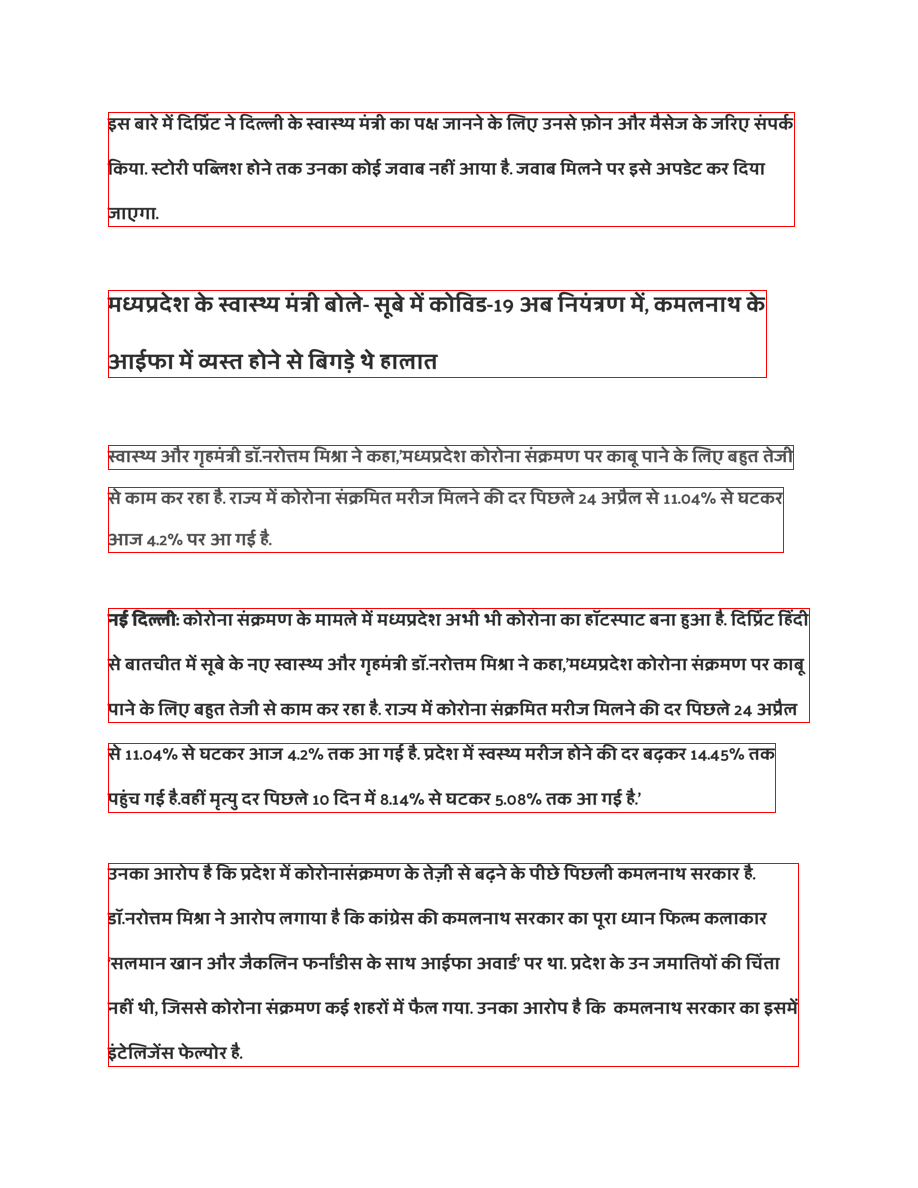

In [56]:
draw_box(img_filepath, page_width, page_height,v_df, color='red')

# Draw bounding box for json response 

In [24]:
from src.services import main

In [65]:
pdf_path = input_dir+"/"+filename
save_path  = save_dir+"/"+str(filename.split('.pdf')[0])
if not os.path.exists(save_path):
    os.system('mkdir -p {0}'.format(save_path))
data = main.DocumentStructure(100,filename, "hi",input_dir)

Total number of pages (9) in file (2035_2009_15_101_17709_Judgement_24-Oct-2019_HIN.xml)
Total number of pages (9) in file (2035_2009_15_101_17709_Judgement_24-Oct-2019_HIN.xml)


/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_right']  = sub_df['text_left'] + sub_df['text_width']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_bottom'] = sub_df['text_top'] + sub_df['text_height']
/home/naresh/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: Set

In [66]:
response = data['result']

In [67]:
def draw_bbox_image(draw,page_data):
    
    if page_data['images']:
        try:
            for image_block in page_data['images']:
                    top     = image_block["text_top"];         left   = image_block["text_left"];  
                    bottom  = top+image_block["text_height"];  right  = left+image_block["text_width"]
                    draw.rectangle(((left, top), (right,bottom)), outline='green')
            return draw
        except:
            pass

In [68]:
def draw_bbox_table(draw,page_data):
    
    if page_data['tables']:
        try:
            for table_block in page_data['tables']:
                    top     = table_block["text_top"];         left   = table_block["text_left"];  
                    bottom  = top+table_block["text_height"];  right  = left+table_block["text_width"]
                    draw.rectangle(((left, top), (right,bottom)), outline='blue')
            return draw
        except:
            pass

In [69]:
def draw_bbox_text(draw,page_data):
    
    if page_data['text_blocks']:
        try:
            for text_block in page_data['text_blocks']:
                top     = text_block["text_top"];         left   = text_block["text_left"];  
                bottom  = top+text_block["text_height"];  right  = left+text_block["text_width"]
                draw.rectangle(((left, top), (right,bottom)), outline='red')
            return draw
        except:
            pass

In [70]:
def draw_bbox_pdf(data,image_files,save_path):
    for page_no in range(len(data)):
        image_path = sorted(image_files)[page_no]
        page_data = data[page_no]
        page_width = page_data['page_width']; page_height = page_data['page_height']
        image  = Image.open(image_path)
        image  = image.resize((page_width, page_height))
        draw   = ImageDraw.Draw(image)
        draw  = draw_bbox_text(draw,page_data)
        draw  = draw_bbox_image(draw,page_data)
        draw  = draw_bbox_table(draw,page_data)
        save_filepath = os.path.join(save_path,image_path.split('images/')[1])
        image.save(save_filepath)
            

In [71]:
draw_bbox_pdf(response,pdf_image_paths,save_path)